In [1]:
import sys
sys.path.insert(0, '../../pyLDLE2/')

import torch
import torch.nn
import torch.optim

import GraphX as gx
import ConnectionGraphX as cgx
import numpy as np
import networkx as nx
from scipy.sparse import lil_matrix
from scipy.linalg import pinv

import ConnectionNetworkX_v2 as cnx

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm import tqdm

from pyLDLE2 import datasets, visualize_

matplotlib.get_backend() =  module://matplotlib_inline.backend_inline


In [2]:
import importlib
importlib.reload(cnx)

<module 'ConnectionNetworkX_v2' from '/home/dhruv/codebase/cgw/connection-graph-wasserstein/ConnectionNetworkX_v2.py'>

In [3]:
def draw3d(G, pos, node_color, node_size, edge_color, figsize=(8,4)):# 3d spring layout
    # Extract node and edge positions from the layout
    node_xyz = np.array([pos[v] for v in sorted(G)])
    edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])

    # Create the 3D figure
    fig = plt.figure(figsize=figsize, constrained_layout=True)
    ax = fig.add_subplot(111, projection="3d")

    # Plot the nodes - alpha is scaled by "depth" automatically
    ax.scatter(*node_xyz.T, c=node_color, s=node_size, ec="w")

    # Plot the edges
    for i in range(edge_xyz.shape[0]):
        vizedge = edge_xyz[i,:]
        ax.plot(*vizedge.T, color=edge_color[i])

    visualize_.set_axes_equal(ax)
    ax.set_xlim(np.min(node_xyz[:,0]), np.max(node_xyz[:,0]))
    ax.set_ylim(np.min(node_xyz[:,1]), np.max(node_xyz[:,1]))
    ax.set_zlim(np.min(node_xyz[:,2]), np.max(node_xyz[:,2]))
    ax.axis('off')
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    plt.margins(0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())

# Load torus data

In [8]:
X, labelsMat, _, img_shape = datasets.Datasets().puppets_data(dirpath='/data2/dhruv/PuppetsData/')

Applying PCA
sum(explained_variance_ratio): 0.9815712482774274
X.shape =  (8100, 100)


In [9]:
inds = np.arange(X.shape[0])
np.random.seed(42)
np.random.shuffle(inds)
n = 3000
inds = inds[:n]
X = X[inds,:]
labelsMat = X[:,:3]

<IPython.core.display.Javascript object>


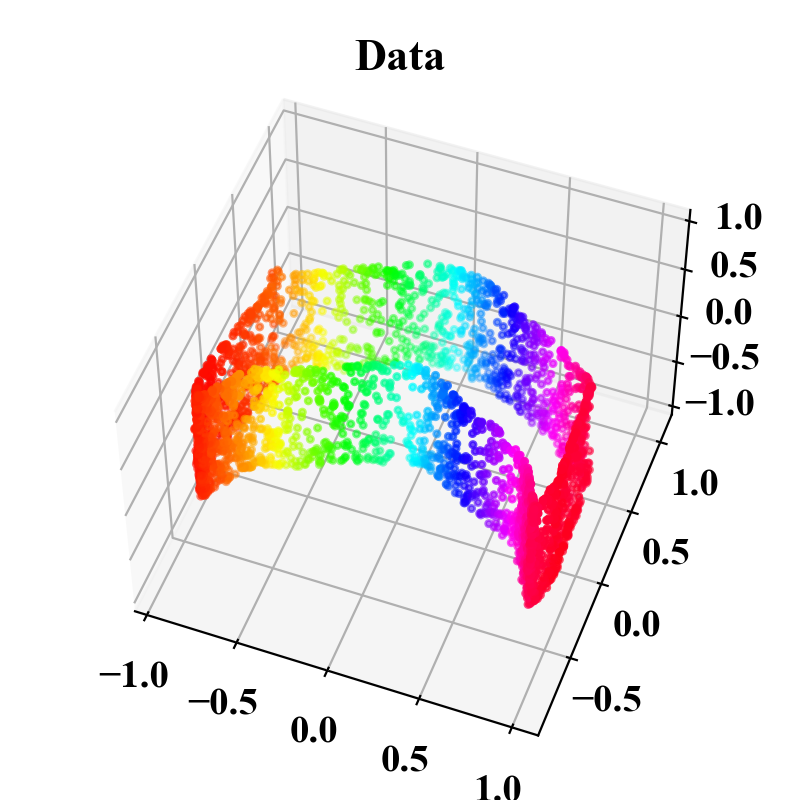

In [12]:
%matplotlib notebook
vis = visualize_.Visualize()
vis.data(X[:,:3], labelsMat[:,0], cmap='hsv', figsize=(4,4))

In [14]:
from scipy.spatial.distance import pdist, squareform
d_e = squareform(pdist(X))

In [15]:
np.sort(d_e[50,:])[:100]

array([0.        , 0.20809397, 0.28183629, 0.36219005, 0.38627455,
       0.40086182, 0.40764827, 0.41536357, 0.42153997, 0.4277848 ,
       0.4299354 , 0.43580799, 0.442931  , 0.47258974, 0.49187341,
       0.49643115, 0.51072796, 0.51987051, 0.52113603, 0.53230236,
       0.5366495 , 0.53955953, 0.55613755, 0.56211858, 0.56557221,
       0.57120714, 0.59234751, 0.60340872, 0.60345129, 0.60420153,
       0.60809338, 0.60917891, 0.60999737, 0.61016218, 0.61313029,
       0.61322935, 0.61334962, 0.61584828, 0.62221073, 0.63153151,
       0.63503302, 0.63678939, 0.6399364 , 0.6411271 , 0.64306574,
       0.64617081, 0.65395698, 0.66204159, 0.6654205 , 0.66700086,
       0.66738155, 0.67049893, 0.67070463, 0.67161458, 0.67219103,
       0.67276316, 0.67289033, 0.67694382, 0.67857871, 0.67920219,
       0.68231574, 0.68415042, 0.69153063, 0.69565225, 0.69729606,
       0.70463694, 0.70473411, 0.70732807, 0.7090082 , 0.7140754 ,
       0.71945935, 0.72243963, 0.72378009, 0.72876888, 0.72929

In [16]:
np.argsort(d_e[50,:])[:1000]

array([  50,  128, 2807,  488, 1739, 1535,  845,  246, 1378, 1814, 2741,
       2410, 1949, 2645, 2548, 1544, 2628, 2488, 1453, 1066,  212, 2865,
       1146, 1895, 1512, 2382, 2717,  136, 1991, 2341,  150, 1938, 2094,
        949,  879,  420, 1614, 2790,  640, 2134, 2786, 1213,  620,  870,
        547, 1610, 1270,  897, 1674,  201, 2432, 1116,  404, 2360,  509,
        287, 1193, 1687, 1684,  910,  904,  838, 2397,  125, 1918, 2245,
       1890, 1794,  888,  625, 1435, 2039, 1278, 2013, 2034, 2300,  281,
       2910, 2949,  324, 1867, 1003, 2007, 1879,  562,  583, 1855, 2814,
       2742, 2149, 1334, 1228, 2349, 2898, 1696, 1360, 2745, 1087,  187,
       1277, 1082,  984, 2520,  594, 1384, 2116, 1571,  638, 1106, 1301,
       1085, 1019, 1425,  338, 2979, 2424,  434, 1617, 2973,    2, 1567,
       1900, 1031, 1113,  738, 1533,  980,   94,  427, 2329,  498, 1330,
       2113,  441,  719, 2664,  435, 1926,  191,   45, 1120, 1369,   33,
       1557, 1361,   18, 2507, 2417, 1321,  519,  9

In [17]:
d_e[50,np.argsort(d_e[50,:])][:100]

array([0.        , 0.20809397, 0.28183629, 0.36219005, 0.38627455,
       0.40086182, 0.40764827, 0.41536357, 0.42153997, 0.4277848 ,
       0.4299354 , 0.43580799, 0.442931  , 0.47258974, 0.49187341,
       0.49643115, 0.51072796, 0.51987051, 0.52113603, 0.53230236,
       0.5366495 , 0.53955953, 0.55613755, 0.56211858, 0.56557221,
       0.57120714, 0.59234751, 0.60340872, 0.60345129, 0.60420153,
       0.60809338, 0.60917891, 0.60999737, 0.61016218, 0.61313029,
       0.61322935, 0.61334962, 0.61584828, 0.62221073, 0.63153151,
       0.63503302, 0.63678939, 0.6399364 , 0.6411271 , 0.64306574,
       0.64617081, 0.65395698, 0.66204159, 0.6654205 , 0.66700086,
       0.66738155, 0.67049893, 0.67070463, 0.67161458, 0.67219103,
       0.67276316, 0.67289033, 0.67694382, 0.67857871, 0.67920219,
       0.68231574, 0.68415042, 0.69153063, 0.69565225, 0.69729606,
       0.70463694, 0.70473411, 0.70732807, 0.7090082 , 0.7140754 ,
       0.71945935, 0.72243963, 0.72378009, 0.72876888, 0.72929

<IPython.core.display.Javascript object>


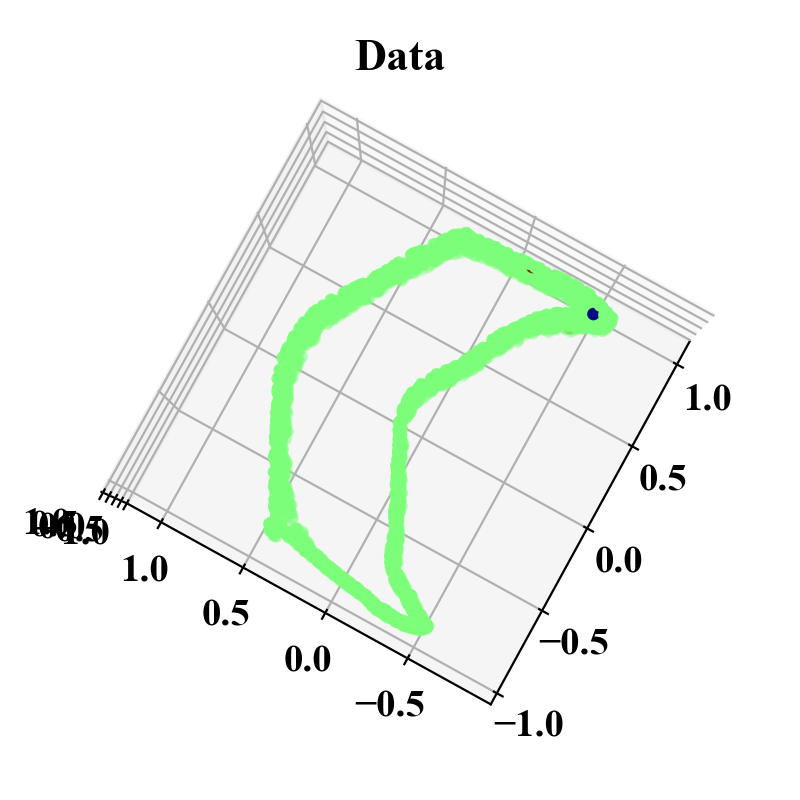

In [24]:
%matplotlib notebook
vis = visualize_.Visualize()
labels = np.zeros(X.shape[0])
labels[50] = -1
labels[1261] = 1
labels[1444] = 1
vis.data(X[:,:3], labels, cmap='jet', figsize=(4,4), s=50, elev=93, azim=137)

#  build connection graph

In [37]:
#NEAREST_NEIGHBORS = 13
INTRINSIC_DIMENSION = 2

#CG = cnx.cnxFromData(X, k=NEAREST_NEIGHBORS, d=INTRINSIC_DIMENSION)
CG = cnx.cnxFromData_v2(X, 0.7, 0.75, d=INTRINSIC_DIMENSION, tol=0.975)

Total edges before removal: 52133


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:30<00:00, 33.27it/s]


Proportion of edges which were removed due to remoteness:  0.4642357048318723


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [04:30<00:00, 11.08it/s]


In [38]:
nx.is_connected(CG)

False

# Set B, w, mu, nu, c

In [39]:
d = INTRINSIC_DIMENSION
n = CG.number_of_nodes()

B = CG.B.T.astype('float32')
W = np.ones(B.shape[0]//d).astype('float32')

np.random.seed(42)
#source = np.random.randint(0, CG.number_of_nodes())
#dest = np.random.randint(0, CG.number_of_nodes())
source = 50 
dest1 = 1261 
dest2 = 1444

mu = np.zeros((n * d, 1))
nu = np.zeros((n * d, 1))
mu[source * d: (source + 1) * d, :] = 1
nu[dest1 * d, :] = 1
nu[dest2 * d+1, :] = 1

c = (mu - nu)

In [40]:
c_sol, residuals, _, _ = np.linalg.lstsq(B.T.toarray(), c)

# I didn't rename the dummy variables here- caution.

np.linalg.norm(c.flatten() - B.T.dot(c_sol).flatten())

/tmp/ipykernel_39968/426106341.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  c_sol, residuals, _, _ = np.linalg.lstsq(B.T.toarray(), c)


1.459755004537336e-14

In [41]:
def optimize_(B, W, c, learning_rate=0.1, alpha=1, n_epochs=10000, phi0=None):
    B_torch = torch.tensor(B.toarray().astype('float32'))
    w_torch = torch.tensor(W.astype('float32'))
    c_torch = torch.tensor(c.astype('float32'))
    
    if phi0 == 'least_squares':
        phi0 = pinv(B.T.dot(B).toarray()).dot(c).astype('float32')
    
    if phi0 is not None:
        print('Initial loss:', cnx.loss_fn(torch.tensor(phi0), B_torch, w_torch, c_torch))
    
    phi = cnx.optimize(B_torch, w_torch, c_torch, alpha, learning_rate, n_epochs, phi0 = phi0)
    return phi.detach().numpy(), phi0

In [42]:
learning_rate = 0.5
alpha = 2000
n_epochs = 10000

phi, phi0 = optimize_(B, W, c, learning_rate=learning_rate, alpha=alpha,
                    n_epochs=n_epochs, phi0='least_squares')

# phi0 = phi

# phi0 = np.ones(B.shape[1], dtype='float32')
# #s_d_path = nx.all_shortest_paths(CG, source ,dest)
# #s_d_path = nx.shortest_path(CG, source ,dest, weight='weight')
# s_d_path = np.unique(list(nx.all_shortest_paths(CG, source ,dest)))
# for i in range(len(s_d_path)):
#     phi0[s_d_path[i]*d:(s_d_path[i]+1)*d] = 10

# phi0 = phi0*np.random.uniform(0, 10, phi0.shape).astype('float32')
# #phi0 = phi0.astype('float32')
# #phi0 = None



Initial loss: (tensor(-0.4006), tensor(0.))
epoch: 0, loss: -0.400619, loss0: -0.400619, loss1: 0.000000
epoch: 10, loss: -20.250469, loss0: -20.389814, loss1: 557.380249
epoch: 20, loss: -39.374622, loss0: -40.269241, loss1: 3578.469727
epoch: 30, loss: -57.620239, loss0: -59.923843, loss1: 9214.421875
epoch: 40, loss: -74.947029, loss0: -79.276382, loss1: 17317.423828
epoch: 50, loss: -91.350853, loss0: -98.278336, loss1: 27709.941406
epoch: 60, loss: -106.853310, loss0: -116.901215, loss1: 40191.609375
epoch: 70, loss: -121.486534, loss0: -135.128448, loss1: 54567.656250
epoch: 80, loss: -135.292450, loss0: -152.949875, loss1: 70629.687500
epoch: 90, loss: -148.311279, loss0: -170.358841, loss1: 88190.273438
epoch: 100, loss: -160.584930, loss0: -187.350662, loss1: 107062.906250
epoch: 110, loss: -172.154694, loss0: -203.921844, loss1: 127068.570312
epoch: 120, loss: -183.063599, loss0: -220.070007, loss1: 148025.593750
epoch: 130, loss: -193.350952, loss0: -235.793777, loss1: 16977

epoch: 1130, loss: -409.013824, loss0: -770.206177, loss1: 1444769.375000
epoch: 1140, loss: -409.135773, loss0: -771.487854, loss1: 1449408.250000
epoch: 1150, loss: -409.251740, loss0: -772.736694, loss1: 1453939.750000
epoch: 1160, loss: -409.361420, loss0: -773.953430, loss1: 1458368.000000
epoch: 1170, loss: -409.465576, loss0: -775.138550, loss1: 1462691.875000
epoch: 1180, loss: -409.563965, loss0: -776.292664, loss1: 1466914.750000
epoch: 1190, loss: -409.656647, loss0: -777.416626, loss1: 1471039.875000
epoch: 1200, loss: -409.745331, loss0: -778.511108, loss1: 1475063.000000
epoch: 1210, loss: -409.828796, loss0: -779.576477, loss1: 1478990.625000
epoch: 1220, loss: -409.908081, loss0: -780.613647, loss1: 1482822.250000
epoch: 1230, loss: -409.982727, loss0: -781.622986, loss1: 1486561.000000
epoch: 1240, loss: -410.053375, loss0: -782.605286, loss1: 1490207.625000
epoch: 1250, loss: -410.119965, loss0: -783.560974, loss1: 1493764.000000
epoch: 1260, loss: -410.182465, loss0:

epoch: 2240, loss: -411.122314, loss0: -811.628845, loss1: 1602026.000000
epoch: 2250, loss: -411.122253, loss0: -811.647217, loss1: 1602099.750000
epoch: 2260, loss: -411.122559, loss0: -811.664734, loss1: 1602168.625000
epoch: 2270, loss: -411.122559, loss0: -811.681091, loss1: 1602234.000000
epoch: 2280, loss: -411.122498, loss0: -811.696716, loss1: 1602296.750000
epoch: 2290, loss: -411.121704, loss0: -811.711426, loss1: 1602358.750000
epoch: 2300, loss: -411.122437, loss0: -811.725342, loss1: 1602411.500000
epoch: 2310, loss: -411.121979, loss0: -811.738525, loss1: 1602466.125000
epoch: 2320, loss: -411.122284, loss0: -811.750977, loss1: 1602514.750000
epoch: 2330, loss: -411.122559, loss0: -811.762634, loss1: 1602560.250000
epoch: 2340, loss: -411.122528, loss0: -811.773682, loss1: 1602604.500000
epoch: 2350, loss: -411.122528, loss0: -811.784119, loss1: 1602646.250000
epoch: 2360, loss: -411.122559, loss0: -811.794067, loss1: 1602686.000000
epoch: 2370, loss: -411.122040, loss0:

epoch: 3350, loss: -411.122406, loss0: -811.940063, loss1: 1603270.500000
epoch: 3360, loss: -411.121979, loss0: -811.940308, loss1: 1603273.250000
epoch: 3370, loss: -411.122131, loss0: -811.940308, loss1: 1603272.625000
epoch: 3380, loss: -411.122650, loss0: -811.940247, loss1: 1603270.250000
epoch: 3390, loss: -411.122681, loss0: -811.940186, loss1: 1603270.000000
epoch: 3400, loss: -411.122528, loss0: -811.940186, loss1: 1603270.500000
epoch: 3410, loss: -411.122040, loss0: -811.940186, loss1: 1603272.500000
epoch: 3420, loss: -411.121918, loss0: -811.940063, loss1: 1603272.500000
epoch: 3430, loss: -411.122314, loss0: -811.940247, loss1: 1603271.625000
epoch: 3440, loss: -411.122467, loss0: -811.940186, loss1: 1603270.750000
epoch: 3450, loss: -411.122589, loss0: -811.940186, loss1: 1603270.250000
epoch: 3460, loss: -411.122589, loss0: -811.940186, loss1: 1603270.250000
epoch: 3470, loss: -411.122467, loss0: -811.940247, loss1: 1603271.000000
epoch: 3480, loss: -411.122192, loss0:

epoch: 4460, loss: -411.122620, loss0: -811.940552, loss1: 1603271.625000
epoch: 4470, loss: -411.122589, loss0: -811.940552, loss1: 1603271.750000
epoch: 4480, loss: -411.122498, loss0: -811.940552, loss1: 1603272.125000
epoch: 4490, loss: -411.121429, loss0: -811.940735, loss1: 1603277.125000
epoch: 4500, loss: -411.121796, loss0: -811.940491, loss1: 1603274.750000
epoch: 4510, loss: -411.122406, loss0: -811.940247, loss1: 1603271.250000
epoch: 4520, loss: -411.122650, loss0: -811.940552, loss1: 1603271.500000
epoch: 4530, loss: -411.122742, loss0: -811.940552, loss1: 1603271.125000
epoch: 4540, loss: -411.122681, loss0: -811.940552, loss1: 1603271.375000
epoch: 4550, loss: -411.122650, loss0: -811.940430, loss1: 1603271.000000
epoch: 4560, loss: -411.122406, loss0: -811.940430, loss1: 1603272.000000
epoch: 4570, loss: -411.122620, loss0: -811.940491, loss1: 1603271.375000
epoch: 4580, loss: -411.122711, loss0: -811.940552, loss1: 1603271.250000
epoch: 4590, loss: -411.122589, loss0:

epoch: 5570, loss: -411.121155, loss0: -811.940979, loss1: 1603279.250000
epoch: 5580, loss: -411.122681, loss0: -811.940186, loss1: 1603270.000000
epoch: 5590, loss: -411.122253, loss0: -811.940552, loss1: 1603273.125000
epoch: 5600, loss: -411.122345, loss0: -811.940430, loss1: 1603272.250000
epoch: 5610, loss: -411.122559, loss0: -811.940552, loss1: 1603271.875000
epoch: 5620, loss: -411.122620, loss0: -811.940491, loss1: 1603271.375000
epoch: 5630, loss: -411.122559, loss0: -811.940552, loss1: 1603271.875000
epoch: 5640, loss: -411.122620, loss0: -811.940552, loss1: 1603271.625000
epoch: 5650, loss: -411.122681, loss0: -811.940552, loss1: 1603271.375000
epoch: 5660, loss: -411.122498, loss0: -811.940491, loss1: 1603271.875000
epoch: 5670, loss: -411.122437, loss0: -811.940369, loss1: 1603271.625000
epoch: 5680, loss: -411.122253, loss0: -811.940247, loss1: 1603271.875000
epoch: 5690, loss: -411.122131, loss0: -811.940186, loss1: 1603272.125000
epoch: 5700, loss: -411.122620, loss0:

epoch: 6680, loss: -411.122070, loss0: -811.940857, loss1: 1603275.125000
epoch: 6690, loss: -411.122406, loss0: -811.940369, loss1: 1603271.750000
epoch: 6700, loss: -411.122528, loss0: -811.940247, loss1: 1603270.750000
epoch: 6710, loss: -411.122681, loss0: -811.940430, loss1: 1603270.875000
epoch: 6720, loss: -411.122681, loss0: -811.940491, loss1: 1603271.125000
epoch: 6730, loss: -411.122559, loss0: -811.940308, loss1: 1603270.875000
epoch: 6740, loss: -411.121399, loss0: -811.939636, loss1: 1603272.875000
epoch: 6750, loss: -411.121796, loss0: -811.939941, loss1: 1603272.500000
epoch: 6760, loss: -411.122345, loss0: -811.940857, loss1: 1603274.000000
epoch: 6770, loss: -411.122528, loss0: -811.940369, loss1: 1603271.250000
epoch: 6780, loss: -411.122681, loss0: -811.940552, loss1: 1603271.375000
epoch: 6790, loss: -411.122650, loss0: -811.940674, loss1: 1603272.000000
epoch: 6800, loss: -411.122589, loss0: -811.940674, loss1: 1603272.250000
epoch: 6810, loss: -411.122253, loss0:

epoch: 7790, loss: -411.122345, loss0: -811.940369, loss1: 1603272.000000
epoch: 7800, loss: -411.122650, loss0: -811.940308, loss1: 1603270.500000
epoch: 7810, loss: -411.122589, loss0: -811.940369, loss1: 1603271.000000
epoch: 7820, loss: -411.122314, loss0: -811.940063, loss1: 1603270.875000
epoch: 7830, loss: -411.122131, loss0: -811.939636, loss1: 1603270.000000
epoch: 7840, loss: -411.121033, loss0: -811.939087, loss1: 1603272.125000
epoch: 7850, loss: -411.122406, loss0: -811.941040, loss1: 1603274.500000
epoch: 7860, loss: -411.122589, loss0: -811.940552, loss1: 1603271.750000
epoch: 7870, loss: -411.122437, loss0: -811.940308, loss1: 1603271.375000
epoch: 7880, loss: -411.122589, loss0: -811.940369, loss1: 1603271.000000
epoch: 7890, loss: -411.122589, loss0: -811.940369, loss1: 1603271.000000
epoch: 7900, loss: -411.122009, loss0: -811.939636, loss1: 1603270.375000
epoch: 7910, loss: -411.121582, loss0: -811.938843, loss1: 1603269.000000
epoch: 7920, loss: -411.122345, loss0:

epoch: 8900, loss: -411.122375, loss0: -811.941650, loss1: 1603277.000000
epoch: 8910, loss: -411.122314, loss0: -811.940491, loss1: 1603272.625000
epoch: 8920, loss: -411.122437, loss0: -811.940186, loss1: 1603270.875000
epoch: 8930, loss: -411.122589, loss0: -811.940430, loss1: 1603271.250000
epoch: 8940, loss: -411.122620, loss0: -811.940430, loss1: 1603271.125000
epoch: 8950, loss: -411.122650, loss0: -811.940674, loss1: 1603272.000000
epoch: 8960, loss: -411.122559, loss0: -811.941345, loss1: 1603275.125000
epoch: 8970, loss: -411.121033, loss0: -811.943298, loss1: 1603289.000000
epoch: 8980, loss: -411.122101, loss0: -811.940674, loss1: 1603274.250000
epoch: 8990, loss: -411.122375, loss0: -811.940002, loss1: 1603270.375000
epoch: 9000, loss: -411.122375, loss0: -811.941101, loss1: 1603274.875000
epoch: 9010, loss: -411.122620, loss0: -811.940369, loss1: 1603270.875000
epoch: 9020, loss: -411.122559, loss0: -811.940369, loss1: 1603271.125000
epoch: 9030, loss: -411.122589, loss0:

In [43]:
def edge_score_(phi, B, W, c):
    B_torch = torch.tensor(B.toarray().astype('float32'))
    w_torch = torch.tensor(W.astype('float32'))
    c_torch = torch.tensor(c.astype('float32'))
    edge_score = cnx.active_edges(torch.tensor(phi), B_torch, w_torch, c_torch)
    return edge_score.detach().numpy()

In [44]:
def optimal_J_(phi, B, W, c, d):
    B_torch = torch.tensor(B.toarray().astype('float32'))
    w_torch = torch.tensor(W.astype('float32'))
    c_torch = torch.tensor(c.astype('float32'))
    J_opt = cnx.optimal_J(torch.tensor(phi), B_torch, w_torch, alpha, d)
    J_opt = J_opt.detach().numpy()
    err = B.T.dot(J_opt.flatten()[:,None]) - c
    print('mean abs err of B^TJ-c', np.mean(np.abs(err)))
    return J_opt

In [45]:
edge_score = edge_score_(phi, B, W, c)
edge_score0 = edge_score_(phi0, B, W, c)
J_opt = optimal_J_(phi, B, W, c, d)
J_opt0 = optimal_J_(phi0, B, W, c, d)

mean abs err of B^TJ-c 0.0013409281313315625
mean abs err of B^TJ-c 0.0006666666666666666


In [46]:
J_opt_norm = np.linalg.norm(J_opt, axis=1)
J_opt0_norm = np.linalg.norm(J_opt0, axis=1)

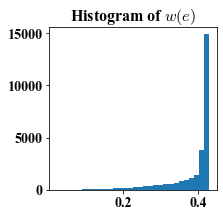

In [47]:
%matplotlib inline
plt.figure(figsize=(3,3))
plt.hist(list(nx.get_edge_attributes(CG, "weight").values()), bins=30)
plt.title('Histogram of $w(e)$')
plt.show()

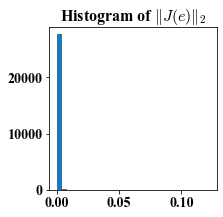

In [48]:
%matplotlib inline
plt.figure(figsize=(3,3))
plt.hist(J_opt_norm, bins=30)
plt.title('Histogram of $\\left\\|J(e)\\right\\|_2$')
plt.show()

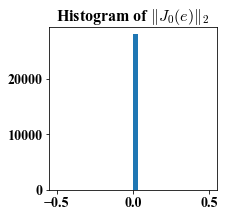

In [49]:
%matplotlib inline
plt.figure(figsize=(3,3))
plt.hist(J_opt0_norm, bins=30)
plt.title('Histogram of $\\left\\|J_0(e)\\right\\|_2$')
plt.show()

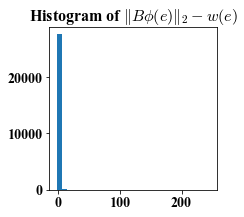

In [50]:
%matplotlib inline
plt.figure(figsize=(3,3))
plt.hist(edge_score, bins=30)
plt.title('Histogram of $\\left\\|B\\phi(e)\\right\\|_2-w(e)$')
plt.show()

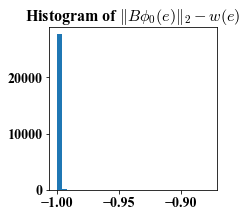

In [51]:
%matplotlib inline
plt.figure(figsize=(3,3))
plt.hist(edge_score0, bins=30)
plt.title('Histogram of $\\left\\|B\\phi_0(e)\\right\\|_2-w(e)$')
plt.show()

In [52]:
from sklearn.manifold import LocallyLinearEmbedding, Isomap
from umap import UMAP
#fit_obj = LocallyLinearEmbedding(n_components=d, n_neighbors=7, method='ltsa')
fit_obj = Isomap(n_components=d, n_neighbors=10)

#fit_obj = UMAP(n_neighbors=100, min_dist=0.5, n_components=3, random_state=42)
embedding = fit_obj.fit_transform(X)

In [53]:
%matplotlib inline
def make_plots(phi, edge_score, J_opt):
    pos = {}
    n = embedding.shape[0]
    for i in range(n):
        pos[i] = embedding[i,:]

    node_size = np.ones(n)*2
    node_size[source] = 50
    node_size[dest1] = 50
    node_size[dest2] = 50
    node_color = ['g']*n
    node_color[source] = "y"
    node_color[dest1] = "r"
    node_color[dest2] = "g"

    Bphi = B.dot(phi).reshape((W.shape[0],-1))
    edge_color = np.linalg.norm(Bphi, axis=1)

    options = {
        "node_color": node_color,
        "edge_color": edge_color,
        "width": 1,
        "edge_cmap": plt.cm.jet,
        "with_labels": False,
    }
    nx.draw(CG, pos=pos, node_size=node_size, **options)
    plt.title('$\left\\|B\\phi(e)\\right\\|_2$')
    plt.show()
    
    ###########
    
    pos = {}
    n = embedding.shape[0]
    for i in range(n):
        pos[i] = embedding[i,:]

    edge_color = (np.linalg.norm(J_opt, axis=1) > 0).astype('float32')

    options = {
        "node_color": node_color,
        "edge_color": edge_color,
        "width": 1,
        "edge_cmap": plt.cm.binary,
        "with_labels": False,
    }
    nx.draw(CG, pos=pos, node_size=node_size, **options)
    plt.title('$\left\\|J(e)\\right\\|_2> 0$')
    plt.show()
    
    ########
    
    
    pos = {}
    n = embedding.shape[0]
    for i in range(n):
        pos[i] = embedding[i,:]

    #edge_color = (np.linalg.norm(J_opt, axis=1) > 0).astype('float32')
    # edge_color = np.concatenate([J_opt[:,0:1]/np.max(J_opt[:,0:1]),
    #                              J_opt[:,1:2]/np.max(J_opt[:,1:2]),
    #                              J_opt[:,0:1]*0.1,  J_opt[:,0:1]*0+1], axis=1)
    edge_color = np.linalg.norm(J_opt, axis=1)
    edge_color = edge_color/np.max(edge_color)

    options = {
        "node_color": node_color,
        "edge_color": edge_color,
        "width": 1,
        "with_labels": False,
        "edge_cmap": plt.cm.jet
    }
    nx.draw(CG, pos=pos, node_size=node_size, **options)
    plt.title('$\left\\|J(e)\\right\\|_2$')
    plt.show()
    
    ##########
    
    pos = {}
    n = embedding.shape[0]
    for i in range(n):
        pos[i] = embedding[i,:]


    J = J_opt
    mask = (edge_score > 0)
    J_ = J[mask,:]

    edge_color = np.zeros((J.shape[0],4))
    edge_color[mask,0] = cm.Greys((J_[:,0]-np.min(J_[:,0]))/np.ptp(J_[:,0]))[:,0]
    edge_color[mask,1] = cm.Greys((J_[:,1]-np.min(J_[:,1]))/np.ptp(J_[:,1]))[:,1]
    edge_color[mask,-1] = edge_score[mask]/np.max(edge_score[mask])
    

    options = {
        "node_color": node_color,
        "edge_color": edge_color,
        "width": 1,
        "with_labels": False,
    }
    nx.draw(CG, pos=pos, node_size=node_size, **options)
    plt.title('$\left\\|(B\\phi)(e)\\right\\|_2- w(e)> 0$')
    plt.show()

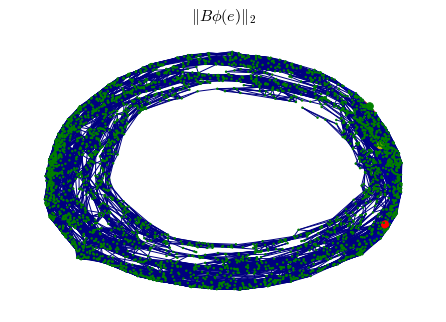

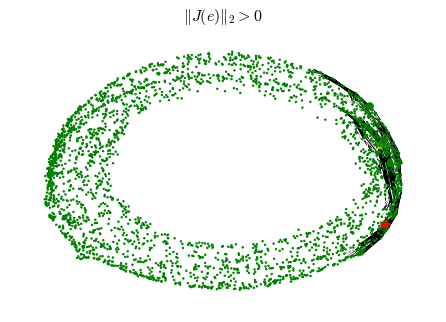

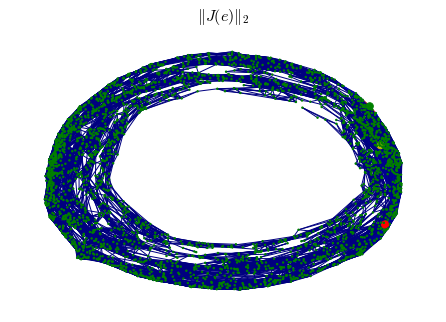

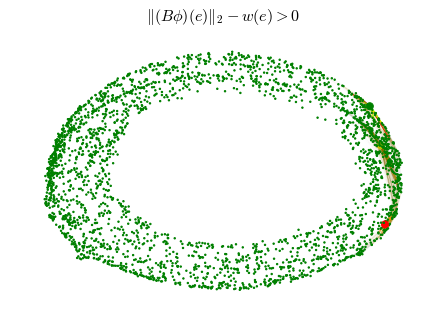

In [54]:
make_plots(phi, edge_score, J_opt)

# 3d network plot

In [66]:
from sklearn.manifold import LocallyLinearEmbedding, Isomap
from umap import UMAP
fit_obj = LocallyLinearEmbedding(n_components=d+1, n_neighbors=7, method='ltsa')
#fit_obj = Isomap(n_components=d+1, n_neighbors=10)

#fit_obj = UMAP(n_neighbors=100, min_dist=0.5, n_components=3, random_state=42)
embedding = fit_obj.fit_transform(X)

In [67]:
theta = nx.get_edge_attributes(CG, 'theta')
theta = np.array(list(theta.values()))
reflection = nx.get_edge_attributes(CG, 'reflection')
reflection = np.array(list(reflection.values()))

In [68]:
#J = B.dot(phi).reshape(CG.number_of_edges(), d)
#J = B.dot(phi0).reshape(CG.number_of_edges(), d)
#J = J_opt0
J = J_opt

/tmp/ipykernel_39968/3389019435.py:23: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(left=0, right=1, bottom=0, top=1)


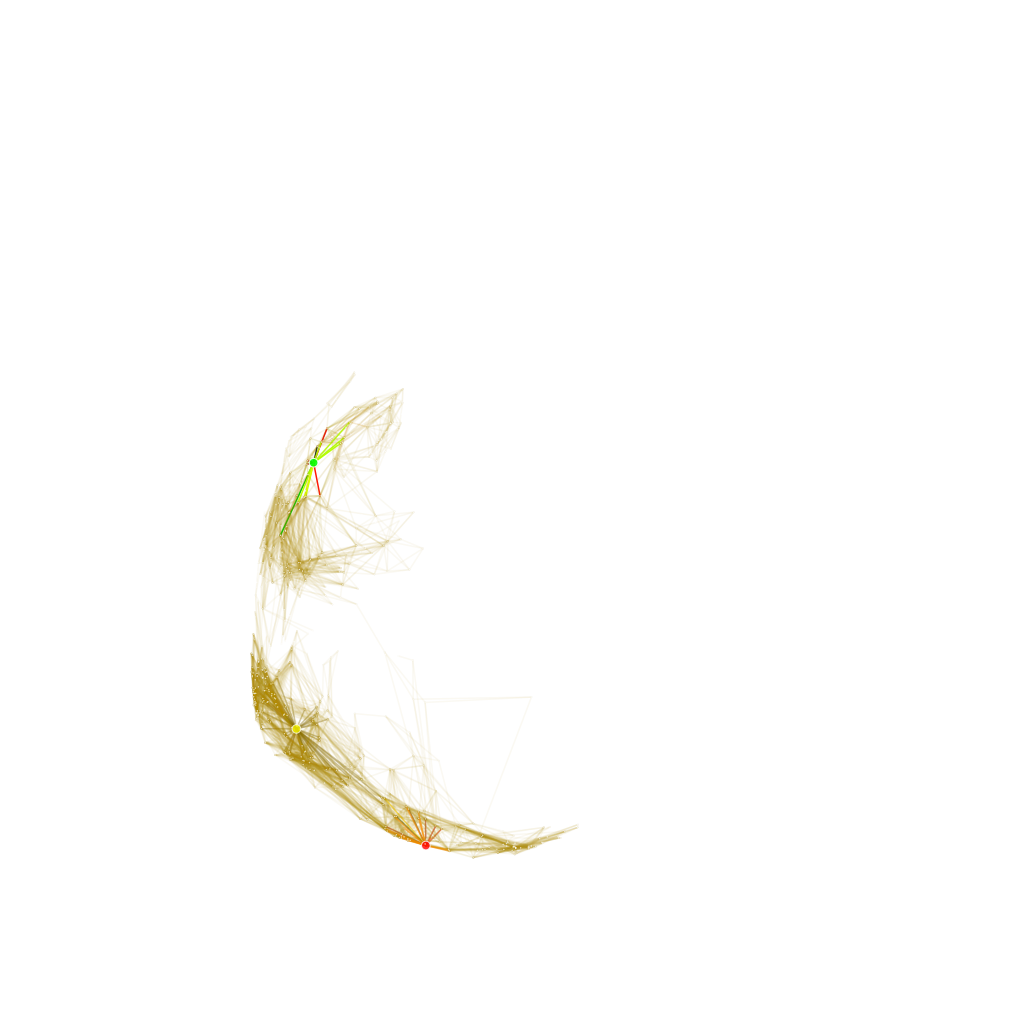

In [73]:
%matplotlib inline
pos = {}
n = embedding.shape[0]
for i in range(n):
    pos[i] = embedding[i,:]

node_size = np.ones(n)*1
node_size[source] = 300
node_size[dest1] = 300
node_size[dest2] = 300
node_color = np.zeros((n,4))
node_color[:,:3] = 1
node_color[source,:] = [1,1,0,1]
node_color[dest1] = [1,0,0,1]
node_color[dest2] = [0,1,0,1]

mask = (edge_score > 0)
J_ = J[mask,:]

edge_color = np.zeros((J.shape[0],4))
edge_color[mask,0] = cm.Greys((J_[:,0]-np.min(J_[:,0]))/np.ptp(J_[:,0]))[:,0]
edge_color[mask,1] = cm.Greys((J_[:,1]-np.min(J_[:,1]))/np.ptp(J_[:,1]))[:,1]

#m_ = (np.max(J_[:,1]) - np.min(J_[:,1]))
#edge_color[mask,:] = cm.jet(J_[:,1] + m_*(J_[:,0] - np.min(J_[:,0]))/(np.max(J_[:,0]) - np.min(J_[:,0])))

#edge_color[:,-1] = (edge_score > 0).astype('float32')
edge_color[mask,-1] = 0.05 + 0.95*(edge_score[mask]-np.min(edge_score[mask]))/np.ptp(edge_score[mask])

draw3d(CG, embedding, node_color, node_size, edge_color, figsize=(14,14))
plt.gca().view_init(elev=42, azim=-134)
plt.show()

/tmp/ipykernel_39968/3389019435.py:23: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(left=0, right=1, bottom=0, top=1)


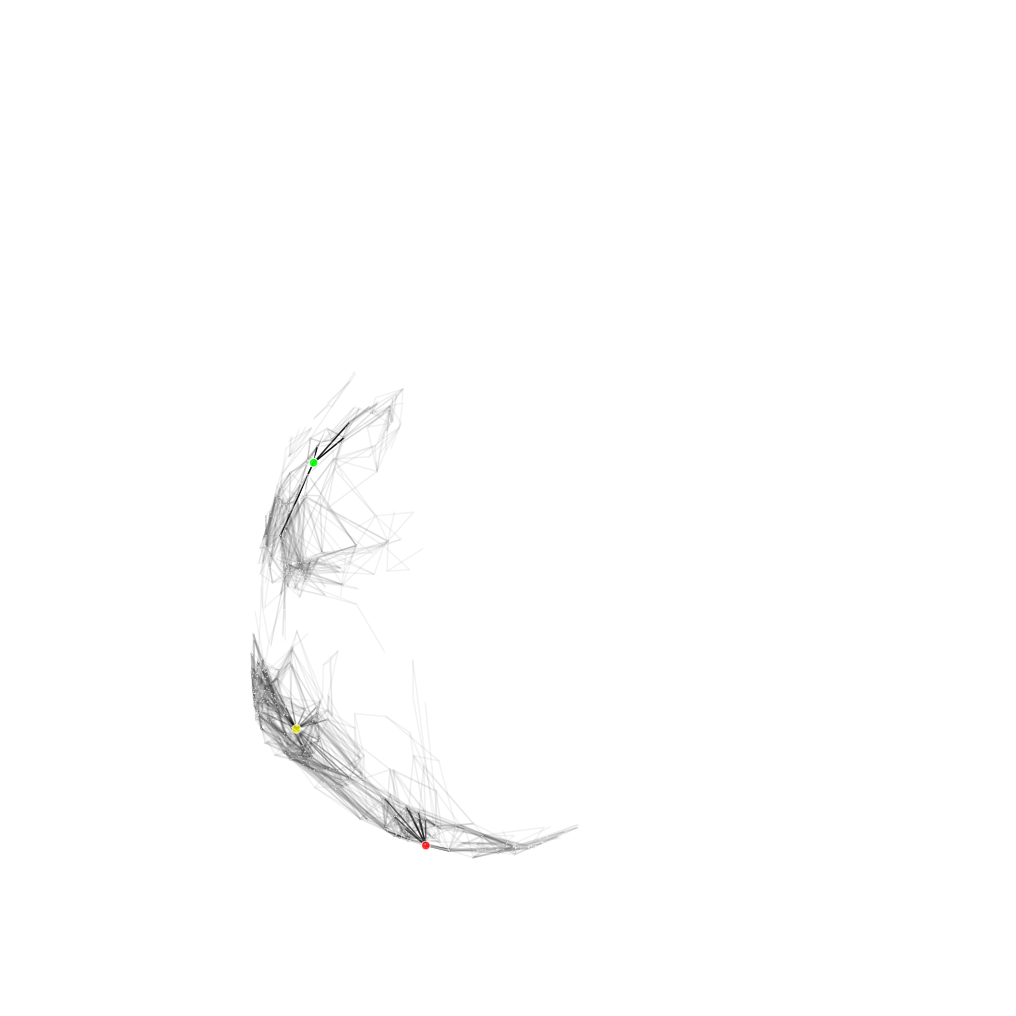

In [71]:
%matplotlib inline
pos = {}
n = embedding.shape[0]
for i in range(n):
    pos[i] = embedding[i,:]

node_size = np.ones(n)*1
node_size[source] = 300
node_size[dest1] = 300
node_size[dest2] = 300
node_color = np.zeros((n,4))
node_color[:,:3] = 1
node_color[source,:] = [1,1,0,1]
node_color[dest1] = [1,0,0,1]
node_color[dest2] = [0,1,0,1]

mask = (edge_score > 0)
J_ = J[mask,:]

edge_color = np.zeros((J.shape[0],4))
edge_color[mask,0] = reflection[mask] > 0
edge_color[mask,1] = edge_color[mask,0]
edge_color[mask,2] = edge_color[mask,0]

#m_ = (np.max(J_[:,1]) - np.min(J_[:,1]))
#edge_color[mask,:] = cm.jet(J_[:,1] + m_*(J_[:,0] - np.min(J_[:,0]))/(np.max(J_[:,0]) - np.min(J_[:,0])))

#edge_color[:,-1] = (edge_score > 0).astype('float32')
edge_color[mask,-1] = 0.05 + 0.95*(edge_score[mask]-np.min(edge_score[mask]))/np.ptp(edge_score[mask])

draw3d(CG, embedding, node_color, node_size, edge_color, figsize=(14,14))
plt.gca().view_init(elev=42, azim=-134)
plt.show()

/tmp/ipykernel_39968/3389019435.py:23: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(left=0, right=1, bottom=0, top=1)


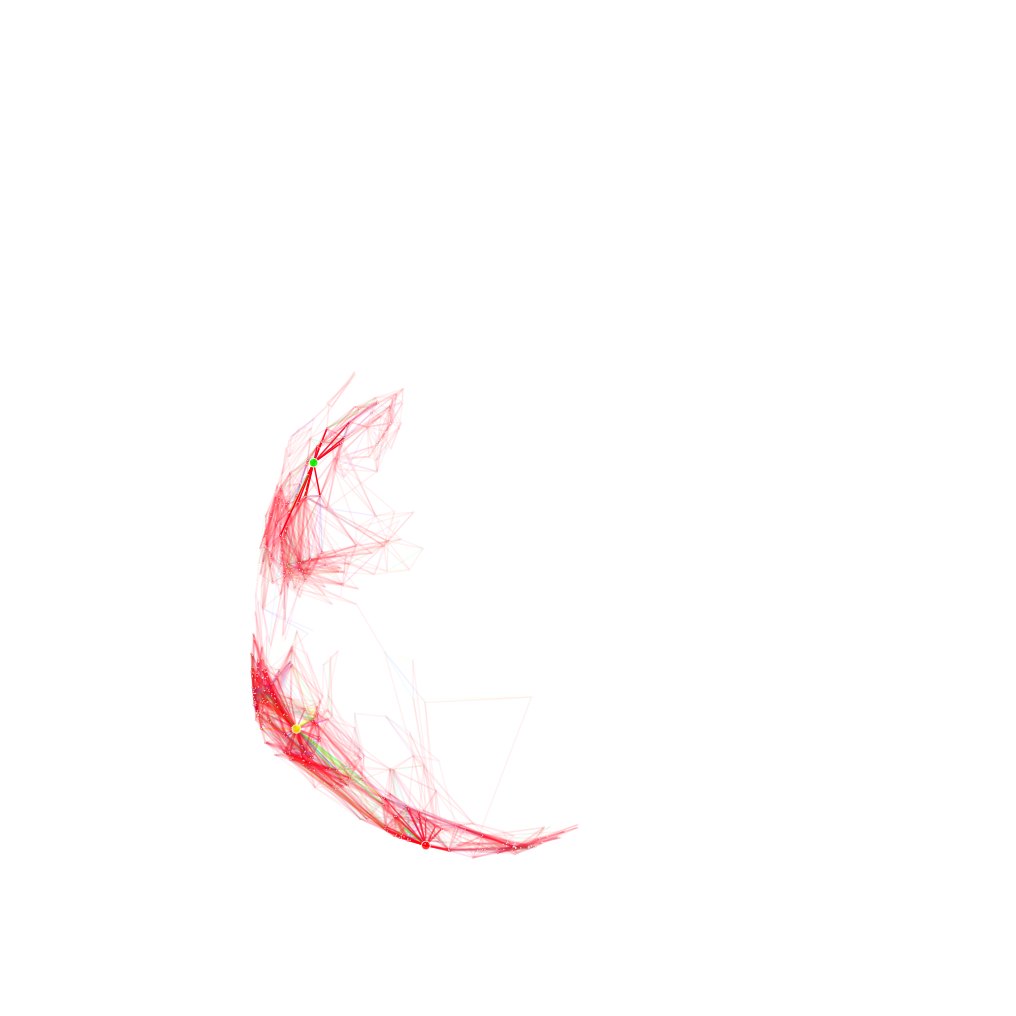

In [72]:
%matplotlib inline
pos = {}
n = embedding.shape[0]
for i in range(n):
    pos[i] = embedding[i,:]

node_size = np.ones(n)*1
node_size[source] = 300
node_size[dest1] = 300
node_size[dest2] = 300
node_color = np.zeros((n,4))
node_color[:,:3] = 1
node_color[source,:] = [1,1,0,1]
node_color[dest1] = [1,0,0,1]
node_color[dest2] = [0,1,0,1]

mask = (edge_score > 0)
J_ = J[mask,:]

edge_color = np.zeros((J.shape[0],4))
edge_color[mask,:] = cm.hsv(theta[mask])

#m_ = (np.max(J_[:,1]) - np.min(J_[:,1]))
#edge_color[mask,:] = cm.jet(J_[:,1] + m_*(J_[:,0] - np.min(J_[:,0]))/(np.max(J_[:,0]) - np.min(J_[:,0])))

#edge_color[:,-1] = (edge_score > 0).astype('float32')
edge_color[mask,-1] = 0.05 + 0.95*(edge_score[mask]-np.min(edge_score[mask]))/np.ptp(edge_score[mask])

draw3d(CG, embedding, node_color, node_size, edge_color, figsize=(14,14))
plt.gca().view_init(elev=42, azim=-134)
plt.show()

In [78]:
node_color_ = phi.reshape((CG.number_of_nodes(), d))

/tmp/ipykernel_17240/3389019435.py:23: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(left=0, right=1, bottom=0, top=1)


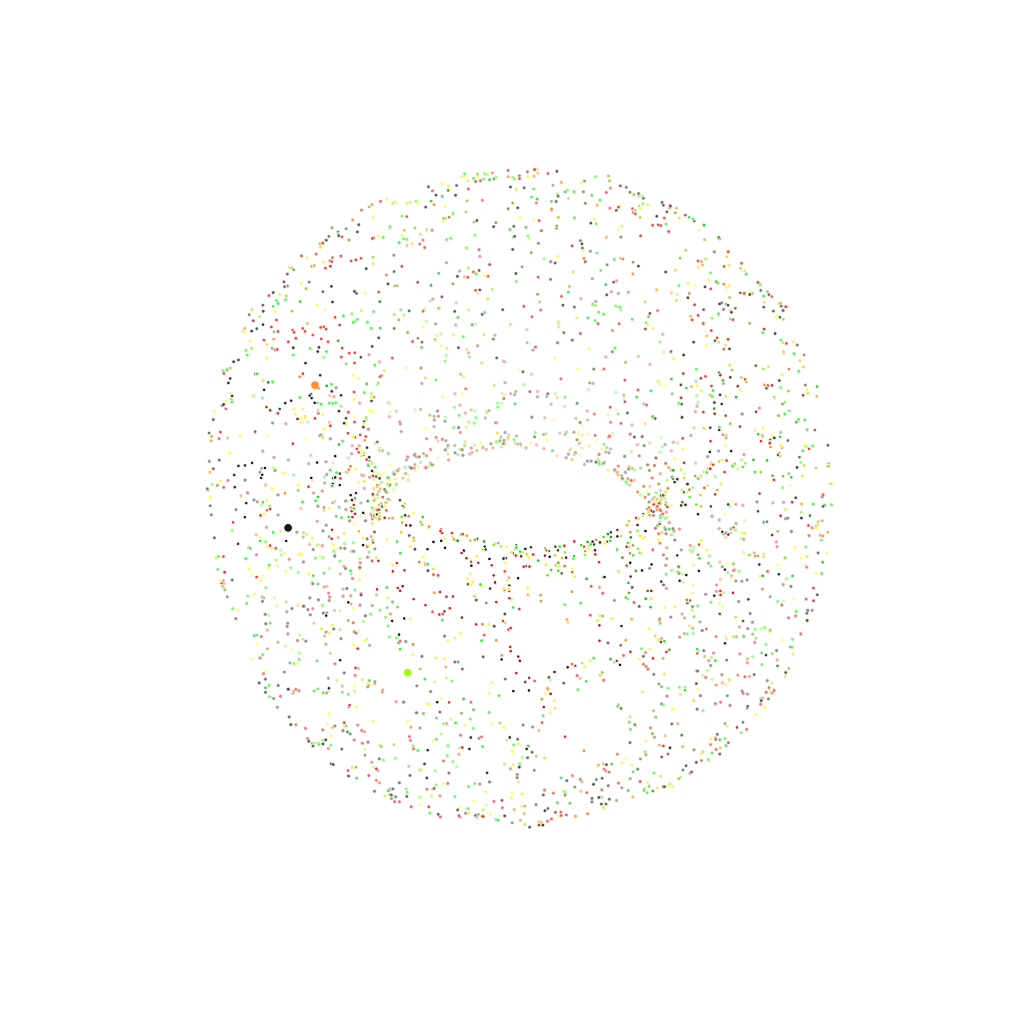

In [80]:
%matplotlib inline
pos = {}
n = embedding.shape[0]
for i in range(n):
    pos[i] = embedding[i,:]

node_size = np.ones(n)*50
node_size[source] = 300
node_size[dest1] = 300
node_size[dest2] = 300
node_color = np.zeros((n,4))
node_color[:,-1] = 1
node_color[:,0] = cm.Greys((node_color_[:,0] - np.min(node_color_[:,0])/np.ptp(node_color_[:,0])))[:,0]
node_color[:,1] = cm.Greys((node_color_[:,1] - np.min(node_color_[:,1])/np.ptp(node_color_[:,1])))[:,1]
edge_color = np.zeros((edge_score.shape[0], 4))
#edge_color = cm.Greys((edge_score > 0).astype('float32'))
#edge_color[:,-1] = (edge_score > 0).astype('float32')

draw3d(CG, embedding, node_color, node_size, edge_color, figsize=(14,14))
plt.gca().view_init(elev=57, azim=-79)
plt.show()